# DDPM

코드 참고 : https://github.com/awjuliani/pytorch-diffusion

https://github.com/tcapelle/Diffusion-Models-pytorch

할거
스케줄링
val -> FID 계산하기 (fid.py에서 import해서 쓰면 될듯?)
메모리 오류나면... batch 줄이기

In [1]:
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import pytorch_lightning as pl
from model import DiffusionModel
from torch.utils.data import DataLoader

c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
diffusion_steps = 1000
max_epoch = 10
img_size = 64
img_channel = 1
batch_size = 4

In [4]:
# Dataloader만들기

transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 18000
Class names: ['with_mask', 'without_mask']


In [5]:
model = DiffusionModel(img_size*img_size, diffusion_steps, img_channel, n_class=2, light=False)
checkpoint = torch.load('DDPM_BASE.ckpt')       # lr : 2e-5 에서 epoch당 0.8씩 11에포크 돌린거
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [6]:
from pytorch_lightning.callbacks import ModelCheckpoint


# "global_step" 기준으로 마지막 10개의 checkpoint만 저장
# make sure you log it inside your LightningModule
checkpoint_callback = ModelCheckpoint(
    dirpath="results/DDPM/",
    #save_top_k=1,
    save_on_train_epoch_end = True,
    #filename="sample-mnist-{epoch:02d}-{global_step}",
    filename="sample-mnist-{epoch:02d}",
)

In [7]:
trainer = pl.Trainer(max_epochs=max_epoch,callbacks=[checkpoint_callback],default_root_dir='results/DDPM/')
trainer.fit(model, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params
---------------------------------------------
0  | label_emb | Embedding     | 512   
1  | inc       | DoubleConv    | 37.7 K
2  | down1     | Down          | 328 K 
3  | down2     | Down          | 1.2 M 
4  | down3     | Down          | 2.4 M 
5  | up1       | Up            | 6.2 M 
6  | up2       | Up            | 1.6 M 
7  | up3       | Up            | 422 K 
8  | sa1       | SelfAtt

Epoch 0: 100%|██████████| 4500/4500 [08:35<00:00,  8.74it/s, v_num=3]0epoch lr : 1.8e-06
train/loss : 0.02556
with_mask ------  val - w/ mask : 222.77677940278568
without_mask ------  val - w/o mask : 245.12473816055098

Epoch 1: 100%|██████████| 4500/4500 [08:36<00:00,  8.70it/s, v_num=3]1epoch lr : 1.62e-06
train/loss : 0.02508
with_mask ------  val - w/ mask : 225.78924016361566
without_mask ------  val - w/o mask : 244.59731892000406

Epoch 2: 100%|██████████| 4500/4500 [08:37<00:00,  8.70it/s, v_num=3]2epoch lr : 1.458e-06
train/loss : 0.02516
with_mask ------  val - w/ mask : 242.50139191662328
without_mask ------  val - w/o mask : 233.97161604281416

Epoch 3:   0%|          | 0/4500 [00:00<?, ?it/s, v_num=3]           

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Of the allocated memory 5.84 GiB is allocated by PyTorch, and 490.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
# 저장
trainer.save_checkpoint('DDPM_FINAL.ckpt')

이미지 생성하기

In [12]:
model = DiffusionModel(img_size*img_size, diffusion_steps, img_channel, n_class=2, light=False)
checkpoint = torch.load('DDPM_lr.ckpt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model.cuda()
print()

In [13]:
from IPython.display import Image as Display
import tqdm

# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in tqdm.tqdm(range(25)):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    x = torch.randn((4, 1, 64, 64)).cuda()
    generated_labels = torch.cuda.IntTensor(4).fill_(0)

    # 이미지 생성
    sample_steps = torch.arange(model.t_range-1, 0, -1).cuda()
    for t in sample_steps:
        x = model.denoise_sample(x, t,generated_labels)
    for j in range(4):
        save_image(x[j], f'./results/DDPM/with_mask/{i * 4 + j}.png', normalize=True)

100%|██████████| 25/25 [15:30<00:00, 37.22s/it]


In [15]:
# 마스크를 착용안한 총 10 * 100개의 얼굴 이미지를 생성
for i in tqdm.tqdm(range(25)):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    x = torch.randn((4, 1, 64, 64)).cuda()
    generated_labels = torch.cuda.IntTensor(4).fill_(1)

    # 이미지 생성
    sample_steps = torch.arange(model.t_range-1, 0, -1).cuda()
    for t in sample_steps:
        x = model.denoise_sample(x, t,generated_labels)
    for j in range(4):
        save_image(x[j], f'./results/DDPM/without_mask/{i * 4 + j}.png', normalize=True)

100%|██████████| 25/25 [15:52<00:00, 38.11s/it]


FID 평가

11 에포크

    with_mask : 145.9

    without_mask : 158.2


21 에포크

    with_mask : 148.3
    without_mask : 164.2

노이즈 이미지 제거 후

    with_mask : 127.4
    without_mask : 158.8

lr 감소 후 

    with_mask : 81.8
    without_mask : 171.9


 Fréchet Inception Distance (FID) 공식 
 
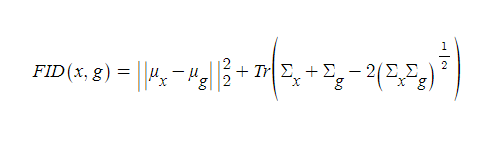

즉, mu와 sigma가 비슷할 수록 낮게 나옴


In [14]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/DDPM/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

Looking for images in ./results/DDPM/with_mask\*.png
Looking for images in ./results/DDPM/with_mask\*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask\*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask\*.jpg
path1 - mu:(2048,) sig:(2048, 2048)
path2 - mu:(2048,) sig:(2048, 2048)
81.82679762908074


c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/DDPM/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

Looking for images in ./results/DDPM/without_mask\*.png
Looking for images in ./results/DDPM/without_mask\*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask\*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask\*.jpg
path1 - mu:(2048,) sig:(2048, 2048)
path2 - mu:(2048,) sig:(2048, 2048)
171.93600636470836


c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./test1 --path2 ./test2 --batch-size 32

Looking for images in ./test1\*.png
Looking for images in ./test1\*.jpg
Looking for images in ./test2\*.png
Looking for images in ./test2\*.jpg
path1 - mu:(2048,) sig:(2048, 2048)
path2 - mu:(2048,) sig:(2048, 2048)
35.37429881681976


c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


without_mask train과 test의 FID는 42 나옴(랜덤으로 골랐을 때)

한쪽을 resize(64,64)하면 164나옴

둘다 resize하면 35나옴

In [6]:
import os

with_mask_path = 'results/DDPM/with_mask'
without_mask_path = 'results/DDPM/without_mask'

for path in [with_mask_path,without_mask_path]:
    file_list = os.listdir(path)
    for i,file_name in enumerate(file_list):
        os.rename(os.path.join(path,file_name), os.path.join(path,str(i+12333)+'.png'))
    file_list = os.listdir(path)
    for i,file_name in enumerate(file_list):
        os.rename(os.path.join(path,file_name), os.path.join(path,str(i)+'.png'))


In [23]:
import os
import cv2

path = 'test2'
file_list = os.listdir(path)

for file_name in file_list:
    file_path = os.path.join(path,file_name)
    image = cv2.imread(file_path)
    
    # 이미지를 목표 크기로 reshape
    resized_image = cv2.resize(image, (64,64))
    
    cv2.imwrite(file_path, resized_image)